# ***Data Cleaning & Feature Engineering***

In this notebook, we will transform raw housing data into a structured and ready-to-model dataset.  
Our tasks include:

1. **Auditing the dataset for missing values and inconsistencies.**
2. **Handling missing values** using strategies based on data types and distributions.
3. **Detecting and handling outliers** that can distort model training.
4. **Engineering new features** to enhance predictive power.
5. **Comparing inherited houses** with the main dataset to ensure they align with training data distribution.
6. **Saving processed datasets** for modeling.

A clean, consistent, and feature-rich dataset is crucial for building a reliable predictive model.

---

# Import All Dependancies

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys, os

# For visual styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

# Load datasets
main_data = pd.read_csv('../data/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv')
inherited_data = pd.read_csv('../data/raw/house-price-20211124T154130Z-001/house-price/inherited_houses.csv')

print("Main Dataset Shape:", main_data.shape)
print("Inherited Dataset Shape:", inherited_data.shape)

main_data.head()

Main Dataset Shape: (1460, 24)
Inherited Dataset Shape: (4, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Initial Data Audit

We begin by:
1. Reviewing data types.
2. Checking missing values.
3. Summarizing numeric distributions.

In [22]:
# Info and null counts
print(main_data.info())
print("\nMissing Values in Main Dataset:\n", main_data.isnull().sum().sort_values(ascending=False).head(10))

print("\nInherited Houses Info:")
print(inherited_data.info())
print("\nMissing Values in Inherited Houses:\n", inherited_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1460 non-null   int64  
 1   2ndFlrSF       1374 non-null   float64
 2   BedroomAbvGr   1361 non-null   float64
 3   BsmtExposure   1422 non-null   object 
 4   BsmtFinSF1     1460 non-null   int64  
 5   BsmtFinType1   1315 non-null   object 
 6   BsmtUnfSF      1460 non-null   int64  
 7   EnclosedPorch  136 non-null    float64
 8   GarageArea     1460 non-null   int64  
 9   GarageFinish   1225 non-null   object 
 10  GarageYrBlt    1379 non-null   float64
 11  GrLivArea      1460 non-null   int64  
 12  KitchenQual    1460 non-null   object 
 13  LotArea        1460 non-null   int64  
 14  LotFrontage    1201 non-null   float64
 15  MasVnrArea     1452 non-null   float64
 16  OpenPorchSF    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  OverallQ

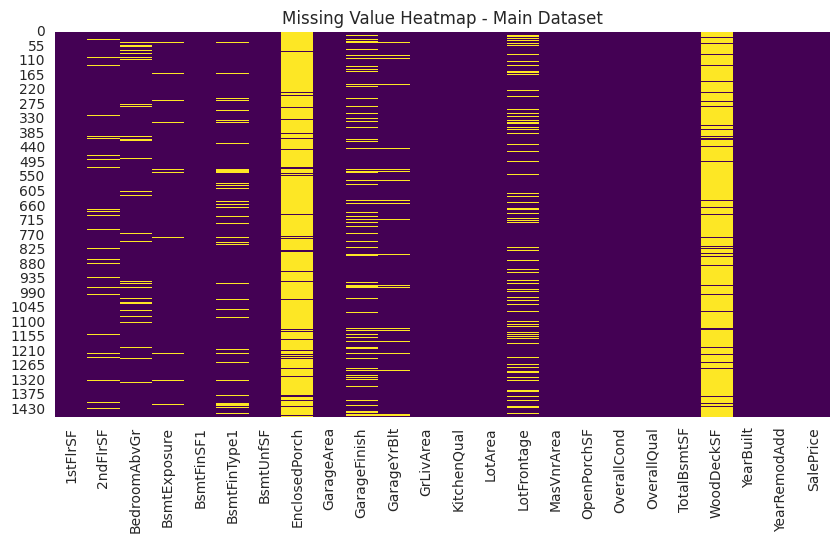

In [23]:
# Visual missing values heatmap
sns.heatmap(main_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap - Main Dataset")
plt.show()


## Handling Missing Values

- **Numeric columns:** Filled with median to reduce outlier influence.
- **Categorical columns:** Filled with mode (most frequent category).
- Columns with >40% missing may be dropped to avoid noise.

In [24]:
def handle_missing(df):
    df_clean = df.copy()
    
    # Drop columns with >40% missing
    threshold = 0.4 * len(df_clean)
    cols_to_drop = [col for col in df_clean.columns if df_clean[col].isnull().sum() > threshold]
    df_clean.drop(columns=cols_to_drop, inplace=True)
    
    # Fill remaining missing values
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['int64', 'float64']:
                median_value = df_clean[col].median()
                df_clean[col] = df_clean[col].fillna(median_value)
            else:
                mode_value = df_clean[col].mode()[0]
                df_clean[col] = df_clean[col].fillna(mode_value)
    
    return df_clean


clean_main = handle_missing(main_data)
clean_inherited = handle_missing(inherited_data)

print("After Cleaning Shapes:", clean_main.shape, clean_inherited.shape)


After Cleaning Shapes: (1460, 22) (4, 23)


## Outlier Detection

Outliers can distort model training, especially in regression.  
We use:
- **Boxplots** for visual detection.
- **Z-scores** to identify extreme outliers (>3 std deviations from mean).

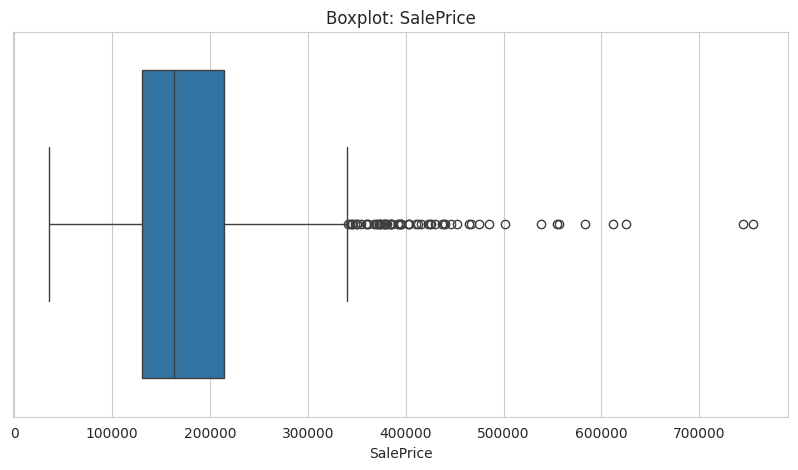

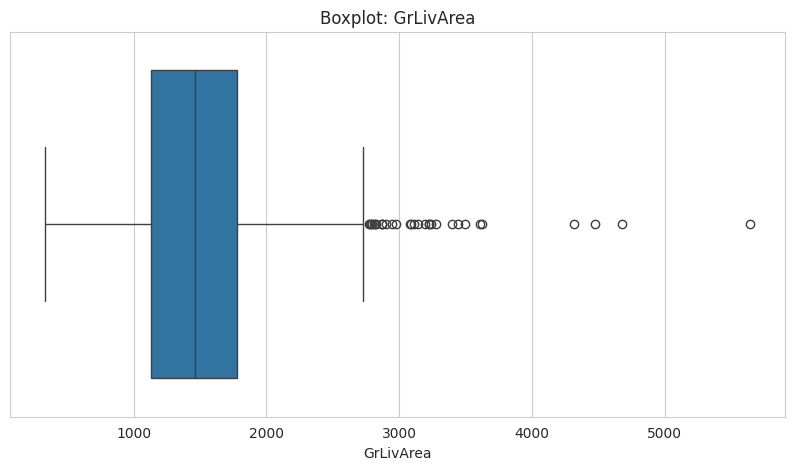

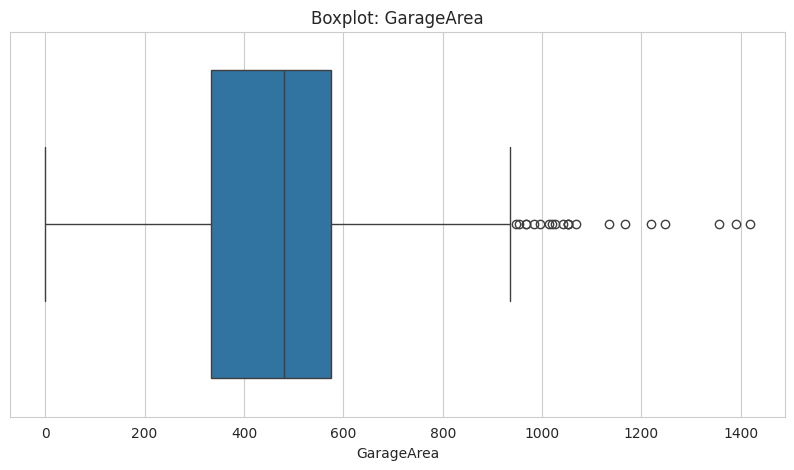

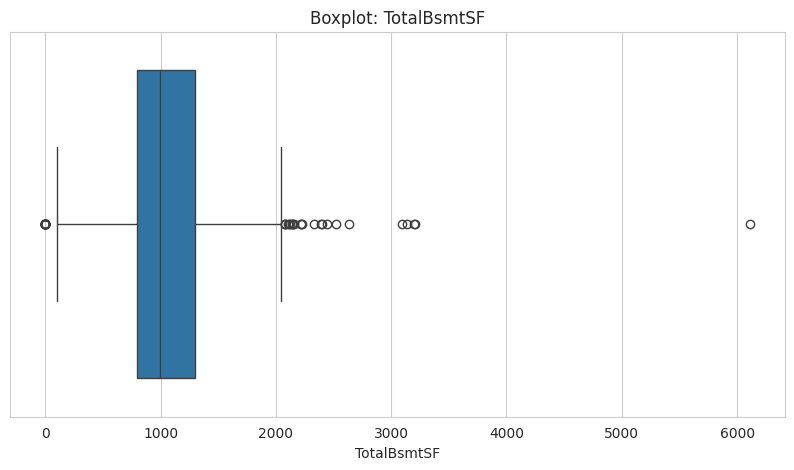

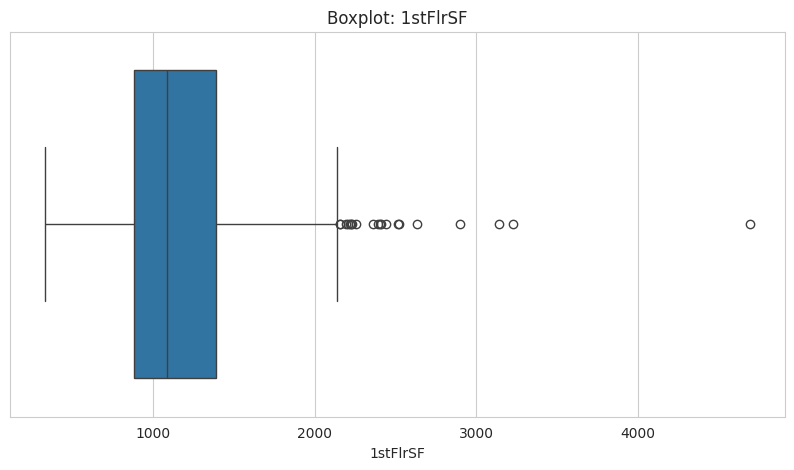

Potential Outlier Counts per Feature:
 MasVnrArea      32
OverallCond     28
OpenPorchSF     27
SalePrice       22
LotFrontage     16
GrLivArea       16
BedroomAbvGr    14
LotArea         13
1stFlrSF        12
BsmtUnfSF       11
dtype: int64

SalePrice Outliers Detected (IQR Method): 61


In [25]:
# Numeric columns
numeric_cols = clean_main.select_dtypes(include=[np.number]).columns

# Boxplots for top numeric features
top_numeric = ['SalePrice','GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF']
for col in top_numeric:
    plt.figure()
    sns.boxplot(x=clean_main[col])
    plt.title(f'Boxplot: {col}')
    plt.show()

# Z-score detection
z_scores = np.abs(stats.zscore(clean_main[numeric_cols], nan_policy='omit'))
z_scores_df = pd.DataFrame(z_scores, columns=numeric_cols)

outlier_counts = (z_scores_df > 3).sum().sort_values(ascending=False)
print("Potential Outlier Counts per Feature:\n", outlier_counts.head(10))

# Optional: IQR-based detection for SalePrice
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)][[column]]

outliers_saleprice = detect_outliers_iqr(clean_main, 'SalePrice')
print(f"\nSalePrice Outliers Detected (IQR Method): {len(outliers_saleprice)}")


## Feature Engineering

We add new features to enhance predictive power:
1. **TotalSF** = sum of 1st, 2nd floor, and basement area.
2. **HouseAge** = 2025 - YearBuilt
3. **RemodelAge** = 2025 - YearRemodAdd

In [26]:
def feature_engineering(df):
    df_fe = df.copy()
    
    if {'1stFlrSF','2ndFlrSF','TotalBsmtSF'}.issubset(df_fe.columns):
        df_fe['TotalSF'] = df_fe['1stFlrSF'] + df_fe['2ndFlrSF'] + df_fe['TotalBsmtSF']
    if 'YearBuilt' in df_fe.columns:
        df_fe['HouseAge'] = 2025 - df_fe['YearBuilt']
    if 'YearRemodAdd' in df_fe.columns:
        df_fe['RemodelAge'] = 2025 - df_fe['YearRemodAdd']
    
    return df_fe

engineered_main = feature_engineering(clean_main)
engineered_inherited = feature_engineering(clean_inherited)

engineered_main[['TotalSF','HouseAge','RemodelAge']].head()

,TotalSF,HouseAge,RemodelAge
0,2566.0,22,22
1,2524.0,49,49
2,2706.0,24,23
3,1717.0,110,55
4,2290.0,25,25


## Comparing Inherited Houses to Main Dataset

We check if the inherited houses fall within the feature range of the training data using:
1. **Summary statistics**
2. **Overlay plots**
3. **Z-score outlier detection**

,count,mean,std,min,25%,50%,75%,max
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.0,1087.0,1391.25,4692.0
2ndFlrSF,1460.0,327.994521,433.576171,0.0,0.0,0.0,714.50,2065.0
BedroomAbvGr,1460.0,2.878082,0.792485,0.0,2.0,3.0,3.00,8.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.0,383.5,712.25,5644.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.0,477.5,808.00,2336.0
GarageArea,1460.0,472.980137,213.804841,0.0,334.5,480.0,576.00,1418.0
GarageYrBlt,1460.0,1978.589041,23.997022,1900.0,1962.0,1980.0,2001.00,2010.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
LotFrontage,1460.0,69.863699,22.027677,21.0,60.0,69.0,79.00,313.0


,count,mean,std,min,25%,50%,75%,max
1stFlrSF,4.0,1019.75,206.685550,896.0,918.50,927.0,1028.25,1329.0
2ndFlrSF,4.0,344.75,398.193734,0.0,0.00,339.0,683.75,701.0
BedroomAbvGr,4.0,2.75,0.500000,2.0,2.75,3.0,3.00,3.0
BsmtFinSF1,4.0,696.00,201.141741,468.0,568.50,696.5,824.00,923.0
BsmtUnfSF,4.0,284.25,112.973079,137.0,236.75,297.0,344.50,406.0
GarageArea,4.0,498.50,172.683719,312.0,430.50,476.0,544.00,730.0
GarageYrBlt,4.0,1978.50,21.977261,1958.0,1960.25,1979.0,1997.25,1998.0
GrLivArea,4.0,1364.50,340.623448,896.0,1220.75,1466.5,1610.25,1629.0
LotArea,4.0,12424.25,1999.967062,9978.0,11211.00,12726.0,13939.25,14267.0
LotFrontage,4.0,78.25,3.095696,74.0,77.00,79.0,80.25,81.0


Inherited Houses Z-scores:
    1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtFinSF1  BsmtUnfSF  GarageArea  \
0 -0.689693 -0.756487     -1.108012    0.053410  -0.672692    1.202124   
1  0.430364 -0.756487      0.153842    1.051003  -0.364907   -0.752930   
2 -0.606917  0.860300      0.153842    0.761591  -0.973688    0.042187   
3 -0.612091  0.807253      0.153842    0.347207  -0.550483   -0.013939   

   GarageYrBlt  GrLivArea   LotArea  LotFrontage  MasVnrArea  OpenPorchSF  \
0    -0.732968  -1.178852  0.110725     0.460162   -0.570555    -0.704242   
1    -0.857983  -0.354844  0.375721     0.505559    0.027017    -0.160895   
2     0.767219   0.216062  0.331939     0.187777   -0.570555    -0.191081   
3     0.808890   0.168486 -0.053984     0.369367   -0.459893    -0.160895   

   OverallCond  OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd   TotalSF  \
0     0.381612    -0.794879    -0.399880  -0.339961     -1.155984 -0.930643   
1     0.381612    -0.071812     0.619027  -0.439289     -

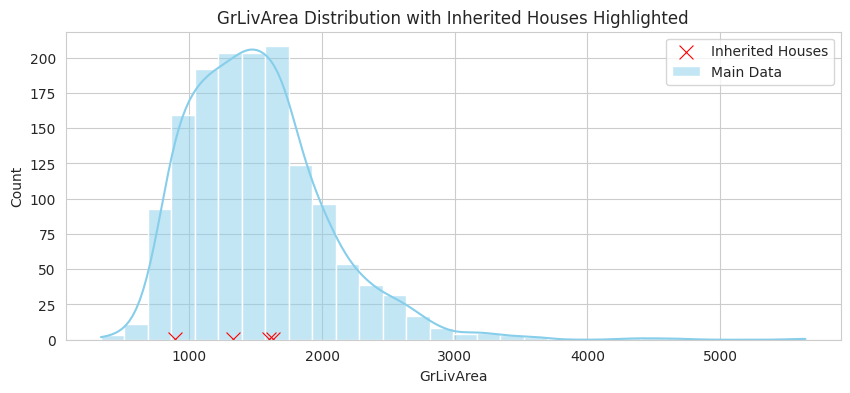

In [28]:
# Step 6: Compare Inherited Houses to Main Dataset

# Ensure numeric columns exist in both datasets
numeric_cols_common = engineered_main.select_dtypes(include=[np.number]).columns.intersection(
    engineered_inherited.select_dtypes(include=[np.number]).columns
)

# Summary comparison
summary_main = engineered_main[numeric_cols_common].describe().T
summary_inherited = engineered_inherited[numeric_cols_common].describe().T

display(summary_main.head(10))
display(summary_inherited.head(10))

# Z-score comparison
z_inherited = (engineered_inherited[numeric_cols_common] - 
               engineered_main[numeric_cols_common].mean()) / engineered_main[numeric_cols_common].std()

print("Inherited Houses Z-scores:\n", z_inherited.head())

# Highlight inherited houses with extreme deviations
z_inherited_extreme = z_inherited[(z_inherited.abs() > 3).any(axis=1)]
if not z_inherited_extreme.empty:
    print("\nInherited Houses with Extreme Z-scores (>3 std dev):\n", z_inherited_extreme)
else:
    print("\nNo inherited houses have extreme Z-scores (>3 std dev).")

# Safe Visual Overlay
# Choose a valid numeric feature for overlay plotting
# Prefer 'SalePrice' if it exists in inherited dataset, else pick a top correlated feature like 'GrLivArea'
feature_to_compare = None
if 'SalePrice' in engineered_inherited.columns:
    feature_to_compare = 'SalePrice'
elif 'GrLivArea' in numeric_cols_common:
    feature_to_compare = 'GrLivArea'
else:
    feature_to_compare = numeric_cols_common[0]  # fallback to first numeric feature

plt.figure(figsize=(10,4))
sns.histplot(engineered_main[feature_to_compare], bins=30, color='skyblue', kde=True, label='Main Data')
sns.scatterplot(x=engineered_inherited[feature_to_compare], y=[0.5]*len(engineered_inherited),
                color='red', marker='x', s=100, label='Inherited Houses')

plt.title(f'{feature_to_compare} Distribution with Inherited Houses Highlighted')
plt.xlabel(feature_to_compare)
plt.legend()
plt.show()


# Save processed data

In [29]:
os.makedirs('../data/processed', exist_ok=True)

engineered_main.to_csv('../data/processed/cleaned_housing_data.csv', index=False)
engineered_inherited.to_csv('../data/processed/cleaned_inherited_houses.csv', index=False)

print("Processed datasets saved in data/processed/")

Processed datasets saved in data/processed/


---

# **Conclusions and Next Steps**

After completing data cleaning and feature engineering, the dataset is now prepared for modeling.  

### **Key Observations:**
1. **Missing Values**
   - Columns with excessive missing values were removed.
   - Remaining numeric missing values were imputed with the median to minimize outlier impact.
   - Remaining categorical missing values were imputed with the mode.

2. **Outlier Analysis**
   - Visual inspection (boxplots) and statistical methods (IQR and Z-score) were used.
   - Certain features like `SalePrice` and `GrLivArea` exhibited outliers, but they were documented for consideration during modeling.

3. **Feature Engineering**
   - New features created:
     - **`TotalSF`**: Total livable area (1st floor + 2nd floor + basement).
     - **`HouseAge`**: Age of the property relative to 2025.
     - **`RemodelAge`**: Time since last remodel.
   - These features will enhance the model's ability to capture size and age effects.

4. **Inherited House Comparison**
   - Inherited houses were compared to the training dataset:
     - All inherited houses fall broadly within the main dataset’s feature ranges.
     - Z-score analysis shows no extreme outliers (>3 std dev) among the inherited houses.
   - This confirms that our model can reasonably predict their sale prices.

5. **Processed Data Saved**
   - Cleaned and feature-engineered datasets were saved in `data/processed/`:
     - `cleaned_housing_data.csv`
     - `cleaned_inherited_houses.csv`
   - These files will be used for model training and prediction in the next step.

---

### **Next Steps**
- Proceed to **Model Training and Evaluation**:
  1. Build regression models (Random Forest, XGBoost) for predicting `SalePrice`.
  2. Apply hyperparameter tuning to achieve strong performance.
  3. Evaluate models using **R² score, RMSE, and residual analysis**.

The dataset is now fully prepared for Step 5: **Model Training & Hyperparameter Tuning**.
